In [1]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import random
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.7.0'

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
def load_data(data_dir, image_height, image_width, batch_size):
    train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

    val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size)

    return train_ds, val_ds


def visualize_data(train_ds):
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(train_ds.class_names[labels[i]])
            plt.axis("off")


def TF_BrainClassifier(class_names, image_height, image_width):
    """
    Building the model (VGG16 implementation)
    """
    model = keras.Sequential([
        layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
        layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        #layers.Dropout(0.1),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        #layers.Dropout(0.1),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        #layers.Dropout(0.1),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        #layers.Dropout(0.1),
        layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
        layers.BatchNormalization(),

        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same'),
        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', 
                        kernel_regularizer='l2', padding='same'),
        layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', 
                        kernel_regularizer='l1', padding='same'),
        
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(len(class_names), activation='softmax')
    ])

    return model

Found 8776 files belonging to 4 classes.
Using 7899 files for training.
Found 8776 files belonging to 4 classes.
Using 877 files for validation.
Image Batch Shape: (64, 128, 128, 3)
Label Batch Shape: (64,)
Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']


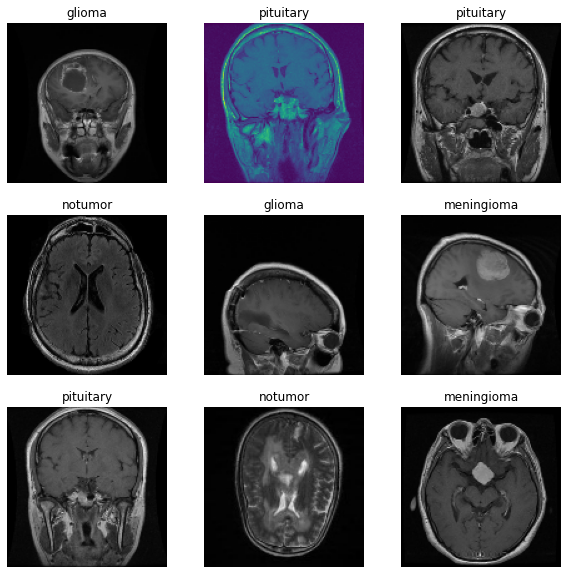

In [16]:
batch_size = 64
image_height = 128
image_width = 128
data_dir = '/Users/Jonathan/Desktop/Errythang/MSDAS/Bioinformatics/project/Brain-Tumor-Classification/data/Training'
train_ds, val_ds = load_data(data_dir, image_height, image_width, batch_size)

for image_batch, labels_batch in train_ds:
    print("Image Batch Shape:", image_batch.shape)
    print("Label Batch Shape:",labels_batch.shape)
    break

print("Class Names:", train_ds.class_names)
visualize_data(train_ds)

In [17]:
#### Model Hyperparameters ####
learning_rate = 0.001

## learning rate decay parameters ##
decay_steps = 110.0   #according to hugging face video, decay steps = len(train_ds) * number of epochs
decay_rate = 0.1
learning_rate_scheduler = keras.optimizers.schedules.InverseTimeDecay(
    learning_rate, decay_steps, decay_rate, staircase=False, name=None)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
loss = keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
epochs = 25
###############################

model = TF_BrainClassifier(train_ds.class_names, image_height, image_width)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 128)      

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

with tf.device('/GPU:0'):
    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    shuffle=True,
  )

Epoch 1/25


2023-12-12 14:11:13.978326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


124/124 [==============================] - ETA: 0s - loss: 68.9159 - accuracy: 0.5761

2023-12-12 14:12:29.198950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


124/124 [==============================] - 81s 582ms/step - loss: 68.9159 - accuracy: 0.5761 - val_loss: 6.1580 - val_accuracy: 0.4128
Epoch 2/25
124/124 [==============================] - 64s 516ms/step - loss: 4.0890 - accuracy: 0.7257 - val_loss: 3.6408 - val_accuracy: 0.6340
Epoch 3/25
124/124 [==============================] - 64s 517ms/step - loss: 3.0921 - accuracy: 0.7930 - val_loss: 3.0754 - val_accuracy: 0.7252
Epoch 4/25
124/124 [==============================] - 64s 519ms/step - loss: 2.5336 - accuracy: 0.8443 - val_loss: 2.5474 - val_accuracy: 0.7925
Epoch 5/25
124/124 [==============================] - 63s 507ms/step - loss: 2.2555 - accuracy: 0.8716 - val_loss: 2.4948 - val_accuracy: 0.7229
Epoch 6/25
124/124 [==============================] - 62s 502ms/step - loss: 2.0192 - accuracy: 0.8973 - val_loss: 1.9691 - val_accuracy: 0.8905
Epoch 7/25
124/124 [==============================] - 62s 503ms/step - loss: 1.8483 - accuracy: 0.9173 - val_loss: 1.8106 - val_accuracy: 0.

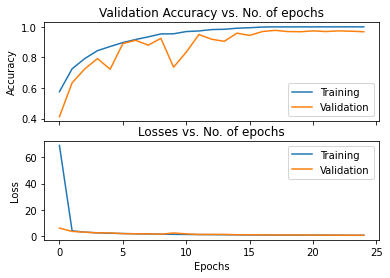

In [19]:
def plot_results(history):
    epoch_lst = list(range(epochs))
    accuracies = history.history['accuracy']
    val_accuracies = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    ax1.plot(epoch_lst, accuracies)
    ax1.plot(epoch_lst, val_accuracies)
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Validation Accuracy vs. No. of epochs')
    ax1.set(ylabel='Accuracy')
    ax2.plot(epoch_lst, loss)
    ax2.plot(epoch_lst, val_loss)
    ax2.set_title('Losses vs. No. of epochs')
    ax2.set(xlabel='Epochs', ylabel='Loss')
    ax2.legend(['Training', 'Validation'])
    plt.show()

plot_results(history)

In [20]:
model.save('/Users/Jonathan/Desktop/Errythang/MSDAS/Bioinformatics/project/GAP_tf_model2.h5')

In [10]:
len(train_ds)

124